# 解决的问题

### 数据信息

数据基于ypjbyc/01_叶片结冰预测/train/15文件夹中的39.39万条数据。

### 数据处理

选择全部数据进行预处理，全部预处理过程约5分钟。

### 算法模型

随机森林
随机森林（RF）是基于决策树的集成算法，利用多棵树对样本进行训练并预测。随机森林采用Bagging方法为每棵决策树生成独立的同分布训练样本集，最终的分类结果取决于所有决策树的投票。使用随机森林进行特征重要性度量的主要思想为评估每个特征在每棵决策树上做的贡献，进行平均值计算，再比较特征贡献值大小。本实验将样本集与26个指数特征输入到随机森林分类模型中，理论上决策树 N 的数量越多其分类准确率越高，时间成本也越高，因此选取生成决策树的数量为100，树的最大深度为146，最大叶子节点数为2500。

# Step 1 读取数据并分类

In [2]:
import os
os.chdir('/Users/janeyang/IAIExamples/2017-IndustryBigData/data/train/15')
import pandas as pd
import numpy as np


data = pd.read_csv("15_data.csv")
total = len(data)
print("sum of data:%d" % total)
des = data.describe()
fail_data = pd.read_csv("15_failureInfo.csv")
normal_data = pd.read_csv("15_normalInfo.csv")

sum of data:393886


## 分类标签：正常时间段和故障时间段

- label = 1: 故障时间区域
- label = 0: 正常时间区域
- label = -1:无效数据

In [3]:
# 转化data时间列为datetime格式
times = []
for i in range(len(data)):
    dt = pd.to_datetime(data.loc[i][0])
    times.append(dt)
    if(i%10000==0):
        print("complete %d / %d" % (i,len(data)))
times = pd.Series(times)
data.time = times

complete 0 / 393886
complete 10000 / 393886
complete 20000 / 393886
complete 30000 / 393886
complete 40000 / 393886
complete 50000 / 393886
complete 60000 / 393886
complete 70000 / 393886
complete 80000 / 393886
complete 90000 / 393886
complete 100000 / 393886
complete 110000 / 393886
complete 120000 / 393886
complete 130000 / 393886
complete 140000 / 393886
complete 150000 / 393886
complete 160000 / 393886
complete 170000 / 393886
complete 180000 / 393886
complete 190000 / 393886
complete 200000 / 393886
complete 210000 / 393886
complete 220000 / 393886
complete 230000 / 393886
complete 240000 / 393886
complete 250000 / 393886
complete 260000 / 393886
complete 270000 / 393886
complete 280000 / 393886
complete 290000 / 393886
complete 300000 / 393886
complete 310000 / 393886
complete 320000 / 393886
complete 330000 / 393886
complete 340000 / 393886
complete 350000 / 393886
complete 360000 / 393886
complete 370000 / 393886
complete 380000 / 393886
complete 390000 / 393886


In [4]:
# 转化normal_data & fail_data时间列为datetime 格式

def to_datetime(obj_pd): 
    Ser1 = obj_pd.iloc[:,0]
    Ser2 = obj_pd.iloc[:,1]
    for i in range(len(Ser1)):
        Ser1[i] = pd.to_datetime(Ser1[i])
        Ser2[i] = pd.to_datetime(Ser2[i])
    obj_pd.iloc[:,0] = Ser1
    obj_pd.iloc[:,1] = Ser2
    return obj_pd
        
normal_data = to_datetime(normal_data)
fail_data = to_datetime(fail_data)

In [5]:
# 根据datetime创建labels列表

labels = []
for i in range(len(times)):
    if(i%100000==0):
        print("complete %d / %d" % (i,len(times)))
    flag = 0
    for j in range(len(normal_data)):
        if((times[i] >= normal_data.startTime[j]) and (times[i] <= normal_data.endTime[j])):
            labels.append(0)
            flag = 1
            break
    for j in range(len(fail_data)):
        if(flag==1):
            break
        elif((times[i] >= fail_data.startTime[j]) and (times[i] <= fail_data.endTime[j])):
            labels.append(1)
            flag = 1
            break
    if(flag == 1):
        continue
    labels.append(-1)
print("complete all")

complete 0 / 393886
complete 100000 / 393886
complete 200000 / 393886
complete 300000 / 393886
complete all


In [6]:
# 打印三类数据信息

def data_category(labels,total):
    sum_inv = 0
    for i in range(len(labels)):
        if(labels[i] == -1):
            sum_inv = sum_inv + 1
    print("sum of invalid data : %d , %.2f %%" % (sum_inv,sum_inv/total*100))
    
    sum_nor = 0
    for i in range(len(labels)):
        if(labels[i] == 0):
            sum_nor = sum_nor + 1
    print("sum of normal data : %d , %.2f %% " % (sum_nor,sum_nor/total*100))
    
    sum_fail = 0
    for i in range(len(labels)):
        if(labels[i] == 1):
            sum_fail = sum_fail + 1
    print("sum of failure data : %d , %.2f %% " % (sum_fail,sum_fail/total*100))
    
data_category(labels,total)

sum of invalid data : 19785 , 5.02 %
sum of normal data : 350255 , 88.92 % 
sum of failure data : 23846 , 6.05 % 


In [7]:
# 删除无效数据
y = labels
indexes = []
for i in range(len(y)):
    if(y[i] == -1):
        indexes.append(i)
data = data.drop(indexes)
data = data.drop('time',axis=1)
for i in range(len(y)-1,-1,-1):
    if(y[i]==-1):
        y.pop(i)

# Step2 模型训练

In [8]:
# 选择训练集和测试集

from sklearn.model_selection import train_test_split
# 在选择的数据中，选择2/3作为训练集，1/3作为测试集
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.33, random_state=666, shuffle = False)# shuffle默认为True

In [9]:
# 归一化
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.fit_transform(X_test)

Optimal number of features : 1
Ranking of features names: Index(['yaw_speed', 'group', 'yaw_position', 'acc_y', 'environment_tmp',
       'wind_direction', 'acc_x', 'pitch1_speed', 'wind_direction_mean',
       'pitch1_angle', 'pitch2_ng5_DC', 'pitch1_ng5_DC', 'pitch3_ng5_tmp',
       'pitch3_angle', 'generator_speed', 'pitch1_moto_tmp', 'int_tmp',
       'pitch3_ng5_DC', 'power', 'pitch2_angle', 'pitch2_moto_tmp',
       'pitch3_speed', 'pitch2_speed', 'pitch3_moto_tmp', 'pitch1_ng5_tmp',
       'pitch2_ng5_tmp', 'wind_speed'],
      dtype='object')
Ranking of features nums: [ 7 27  6 18 19  4 17 11  5  8 25 24 23 10  2 14 20 26  3  9 15 13 12 16
 21 22  1]


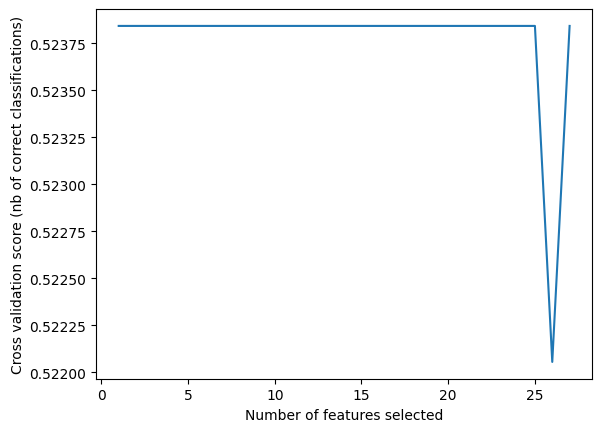

In [10]:
# 特征选择
# 使用RFECV进行特征选择，以交叉验证分数高低决定选取的特征数量
# 对特征进行排名
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline
svc = SVC(kernel="linear")
dt = DecisionTreeClassifier()
rfecv = RFECV(estimator=dt, step=1, cv=StratifiedKFold(2), scoring='accuracy')
rfecv.fit(X_train, y_train)
print("Optimal number of features : %d" % rfecv.n_features_)
print("Ranking of features names: %s" % X_train.columns[rfecv.ranking_-1])
print("Ranking of features nums: %s" % rfecv.ranking_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
# Extract scores and determine number of steps
mean_scores = rfecv.cv_results_['mean_test_score']
n_features = len(mean_scores)

# Plot with corrected x/y values
# 绘制交叉验证下的特征选择折线
plt.plot(range(1, n_features + 1), mean_scores[::-1])
plt.savefig("feature.jpg")
plt.show()

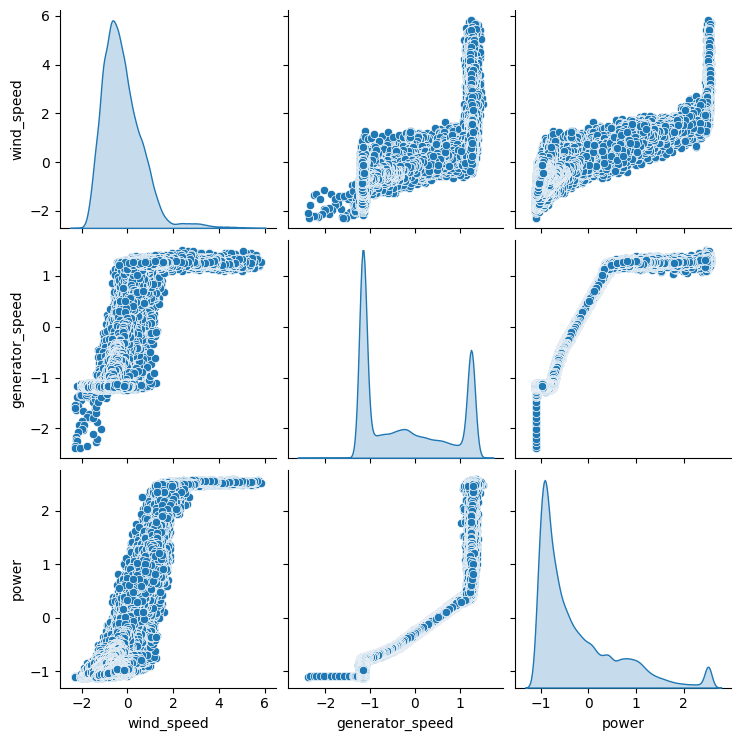

In [11]:
# 选取得分前三的特征，绘制特征对比图
import seaborn as sns
sns.pairplot(X_train, vars=["wind_speed","generator_speed", "power"],
             #palette="husl",
             diag_kind="kde")
plt.savefig("duibi.jpg")

# 训练模型1:随机森林

模型参数选择：
- 选择树的最⼤大深度为146
- 树的最⼤大节点数 2500
- 节点拆分最小用力数量：2
- 叶子结点最少样本数：2
- 集成决策树个数：2500
- 最少的叶子节点数：2500
- Bagging中每个字模型每次放回抽样选取的样本个数
- 当寻找最佳分割时要考虑的特征数量：sqrt
- 评价模型标准：Out Of Bag
原文链接：https://blog.csdn.net/zhaohaibo_/article/details/81876044

In [12]:
# 网格搜索随机森林最佳参数 
def GridsearchCV():
    param_grid = [
        {
            'n_estimators':[i for i in range(500,510)],
            'oob_score':True,
            'random_state':[i for i in range(30,50)],
            'min_samples_split':[i for i in range(2,20)],
            'max_depth': [i for i in range(100,200)], 
        }]
    rf_clf = RandomForestClassifier(max_depth=146,n_estimators=500,
                                    max_leaf_nodes=2500, oob_score=True)
    grid_search = GridSearchCV(rf_clf, param_grid,n_jobs=-1)
    grid_search.fit(X,y)
    grid_search.best_score_
    grid_search.best_estimator_
    

In [13]:
# 忽略寻参过程。 这里直接使用固定参数的随机森林分类器
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(max_depth=146,n_estimators=2500, 
                                    max_leaf_nodes=2500, oob_score=True, random_state=30, n_jobs=-1)
rf_clf.fit(X_train, y_train)
y_predict = rf_clf.predict(X_test)
print(rf_clf.oob_score_)

0.9999920206505564


Confusion matrix, without normalization
[[59560 58110]
 [ 1583  4201]]


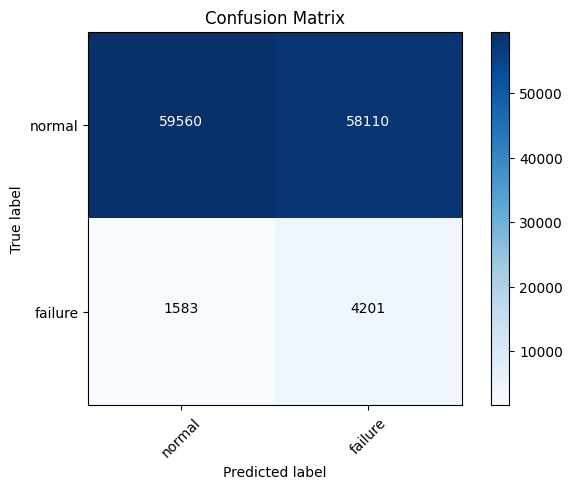

In [14]:
# 混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    """
    Normalization can be applied by setting `normalize = True`.
    """
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    print(cm)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("matrix.jpg")
    
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

prediction = rf_clf.predict(X_test)
cm = confusion_matrix(y_test, prediction)
cm_plot_labels = ['normal', 'failure']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [15]:
# 评价
#precision & recall & f1-score
from sklearn.metrics import classification_report
print(classification_report(y_true=y_test, y_pred=prediction))

              precision    recall  f1-score   support

           0       0.97      0.51      0.67    117670
           1       0.07      0.73      0.12      5784

    accuracy                           0.52    123454
   macro avg       0.52      0.62      0.39    123454
weighted avg       0.93      0.52      0.64    123454



In [16]:
from sklearn.metrics import matthews_corrcoef,accuracy_score,recall_score,precision_score,f1_score

def evaluate_model(y_true, y_pred, y_prob=None):
    """
    综合评估分类模型
    
    参数:
    y_true: 真实标签
    y_pred: 预测标签
    y_prob: 预测概率（可选，用于计算AUC-ROC）
    
    返回:
    metrics: 包含各种评估指标的字典
    """
    # 确保输入是 NumPy 数组
    if isinstance(y_true, list):
        y_true = np.array(y_true)
    if isinstance(y_pred, list):
        y_pred = np.array(y_pred)
    
    # 计算各种指标
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'mcc': matthews_corrcoef(y_true, y_pred)
    }
    
    # 如果有概率预测，计算 AUC-ROC
    if y_prob is not None:
        try:
            metrics['auc_roc'] = roc_auc_score(y_true, y_prob)
        except:
            metrics['auc_roc'] = None
    
    # 打印结果
    print("模型评估结果:")
    for key, value in metrics.items():
        if value is not None:
            print(f"{key}: {value:.4f}")
    
    return metrics

In [17]:
# 使用评估函数
model_metrics = evaluate_model(y_test, prediction)

模型评估结果:
accuracy: 0.5165
precision: 0.0674
recall: 0.7263
f1: 0.1234
mcc: 0.0983
